In [141]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc, f1_score
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_recall_curve
import imageio.v2 as imageio
import random

# Details of make_classification function
- https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html



# 실습 1 : TPR과 FPR로 그려진 AUROC


In [142]:
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1000)

In [143]:
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=1000)

print('trainy - class0: ', len(trainy)-trainy.sum())
print('trainy - class1: ', trainy.sum())
print('----------------------')
print('testy - class0: ', len(testy)-testy.sum())
print('testy - class1: ', testy.sum())
print('============================')

# make testing dataset balance
undersample = RandomUnderSampler(sampling_strategy='majority')
testX, testy = undersample.fit_resample(testX, testy)

print('Balanced Testing date')
print('testy - class0: ', len(testy)-testy.sum())
print('testy - class1: ', testy.sum())

trainy - class0:  253
trainy - class1:  247
----------------------
testy - class0:  249
testy - class1:  251
Balanced Testing date
testy - class0:  249
testy - class1:  249


In [144]:
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)

LogisticRegression()

nth 0:positive: 249 negative: 249
---------------------------------------------
nth 1:positive: 225 negative: 249
---------------------------------------------
nth 2:positive: 200 negative: 249
---------------------------------------------
nth 3:positive: 175 negative: 249
---------------------------------------------
nth 4:positive: 150 negative: 249
---------------------------------------------
nth 5:positive: 125 negative: 249
---------------------------------------------
nth 6:positive: 100 negative: 249
---------------------------------------------
nth 7:positive: 75 negative: 249
---------------------------------------------
nth 8:positive: 50 negative: 249
---------------------------------------------
nth 9:positive: 25 negative: 249
---------------------------------------------


Text(0.5, 1.0, 'decreasing positive sample')

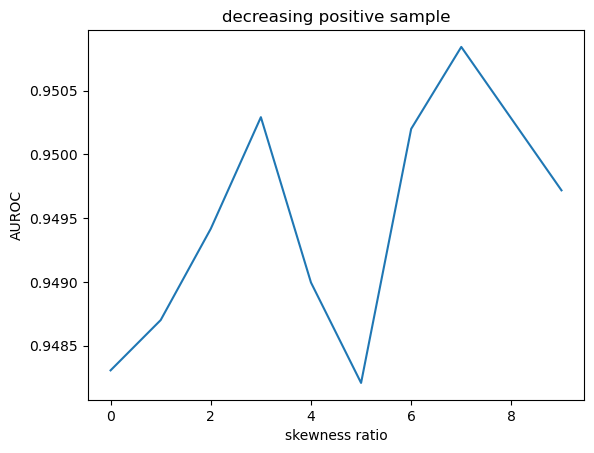

In [145]:
# repeat with different skewness
roc_list = []
lr_acc = []
k=1
for i in range(0, 10):
  pos_ind = np.where(testy==1)[0]
  n = int(i/10 * len(pos_ind))
  tmp_testX, tmp_testy = np.copy(testX), np.copy(testy)
  tmp_testX = np.delete(tmp_testX, pos_ind[:n], axis=0)
  tmp_testy = np.delete(tmp_testy, pos_ind[:n], axis=0)
  print('nth %d:positive: %d negative: %d'
        % (i, tmp_testy.sum(), tmp_testy.shape[0] - tmp_testy.sum()))
  print('---------------------------------------------')

  # predict probabilities
  lr_probs = model.predict_proba(tmp_testX)
  # keep probabilities for the positive outcome only
  lr_probs = lr_probs[:, 1]
  # calculate scores
  lr_auc = roc_auc_score(tmp_testy, lr_probs)

  # summarize scores
  # print('iteration %d: Logistic: ROC AUC=%.3f' % (k, lr_auc))
  k += 1
  # calculate roc curves
  lr_fpr, lr_tpr, _ = roc_curve(tmp_testy, lr_probs)
  roc_list.append(lr_auc)

plt.plot(np.arange(0, len(roc_list)), roc_list)
plt.xlabel('skewness ratio')
plt.ylabel('AUROC')
plt.title('decreasing positive sample')


## 질문 1: 데이터 불균형이 심해지는데 AUROC 평가 지표는 왜 높게 형성이 될까요?

## 답변 1
-

AUROC는 TPR(True Positive Rate)과 FPR(False Positive Rate)을 커브로 그린 것입니다.
실습 코드는 Negative는 유지하고 Positive를 줄여나가면서 데이터 불균형을 만들고, 이에 따라 AUROC가 어떻게 변화하는지를 보여줍니다. 

결과를 봤을 때 AUROC는 데이터 뷸균형이 발생해도 높은 값을 유지하고 있는데, 이는 TPR은 TP/(TP+FN), FPR은 FP/(FP+TN) 이기 때문입니다.
실습 1번에서는 Positive 데이터를 줄여가며 Negative가 압도적으로 많아지는 상황을 만들었고, 이 경우 TN의 절대적인 수가 매우 커지게 되어, FP가 일부 발생해도 FPR = FP/(FP+TN)의 분모가 크기 때문에 FPR이 낮게 유지됩니다.

이러한 결과를 봤을 때, AUROC는 데이터 불균형에 둔감한 지표이며, 불균형 데이터에서는 Precision, Recall 등의 지표를 함께 확인해야 합니다.

# 실습 2 : Precision, Recall, F1 Score의 이해


In [146]:
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1000)

In [147]:
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=1000)

print('trainy - class0: ', len(trainy)-trainy.sum())
print('trainy - class1: ', trainy.sum())
print('----------------------')
print('testy - class0: ', len(testy)-testy.sum())
print('testy - class1: ', testy.sum())
print('============================')

# make testing dataset balance
undersample = RandomUnderSampler(sampling_strategy='majority')
testX, testy = undersample.fit_resample(testX, testy)

print('Balanced Testing date')
print('testy - class0: ', len(testy)-testy.sum())
print('testy - class1: ', testy.sum())

trainy - class0:  253
trainy - class1:  247
----------------------
testy - class0:  249
testy - class1:  251
Balanced Testing date
testy - class0:  249
testy - class1:  249


In [148]:
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)

LogisticRegression()

nth 0:positive: 249 negative: 249
---------------------------------------------
nth 1:positive: 225 negative: 249
---------------------------------------------
nth 2:positive: 200 negative: 249
---------------------------------------------
nth 3:positive: 175 negative: 249
---------------------------------------------
nth 4:positive: 150 negative: 249
---------------------------------------------
nth 5:positive: 125 negative: 249
---------------------------------------------
nth 6:positive: 100 negative: 249
---------------------------------------------
nth 7:positive: 75 negative: 249
---------------------------------------------
nth 8:positive: 50 negative: 249
---------------------------------------------
nth 9:positive: 25 negative: 249
---------------------------------------------


Text(0.5, 1.0, 'decreasing positive sample')

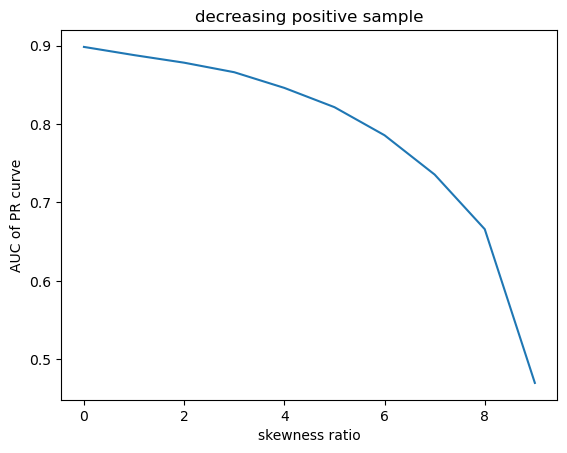

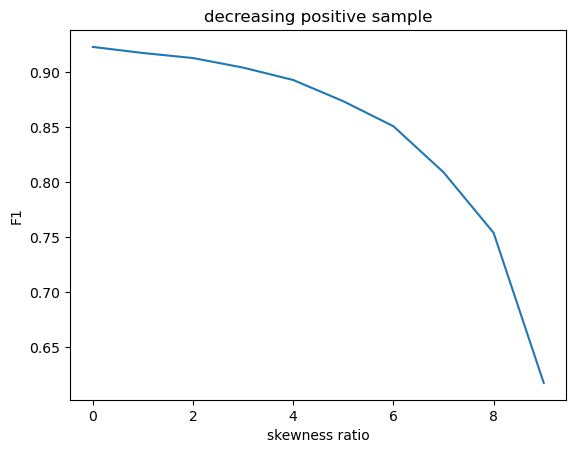

In [149]:
roc_list = []
f1_list = []

k=1
for i in range(0, 10):
  pos_ind = np.where(testy==1)[0]
  n = int(i/10 * len(pos_ind))
  tmp_testX, tmp_testy = np.copy(testX), np.copy(testy)
  tmp_testX = np.delete(tmp_testX, pos_ind[:n], axis=0)
  tmp_testy = np.delete(tmp_testy, pos_ind[:n], axis=0)
  print('nth %d:positive: %d negative: %d'
        % (i, tmp_testy.sum(), tmp_testy.shape[0] - tmp_testy.sum()))
  print('---------------------------------------------')


  # predict probabilities
  lr_probs = model.predict_proba(tmp_testX)
  # keep probabilities for the positive outcome only
  lr_probs = lr_probs[:, 1]
  # predict class values
  yhat = model.predict(tmp_testX)
  # calculate precision and recall for each threshold
  lr_precision, lr_recall, _ = precision_recall_curve(tmp_testy, lr_probs)
  # calculate scores
  lr_f1, lr_auc = f1_score(tmp_testy, yhat), auc(lr_recall, lr_precision)
  # summarize scores
  # print('iteration%d Logistic: f1=%.3f auc=%.3f' % (k, lr_f1, lr_auc))
  k += 1
  roc_list.append(lr_auc)
  f1_list.append(lr_f1)

plt.plot(np.arange(0, len(roc_list)), roc_list)
plt.xlabel('skewness ratio')
plt.ylabel('AUC of PR curve')
plt.title('decreasing positive sample')

plt.figure()
plt.plot(np.arange(0, len(roc_list)), f1_list)
plt.xlabel('skewness ratio')
plt.ylabel('F1')
plt.title('decreasing positive sample')


## 질문 2: AUC, RC Curve와 F1 Curve는 데이터 불균형에 강건한 평가지표인가요? 강건하다면 AUROC보다  강건한 이유를, 그렇지 않다면 강건하지 않은 이유를 설명해주세요.

## 답변 2

실습 2는 PR Curve, F1 Score에 대한 내용입니다.
PR Curve는 Precision, Recall을 Curve로 그린 거고 각각은 아래와 같습니다.
- Precision: TP/(TP+FP): 모델 예측의 신뢰도
- Recall: TP/(TP+FN): 실제 정답을 놓치지 않고 얼마나 잘 찾아냈는지?
또한, F1 Score는 Precision과 Recall의 조화평균입니다.
F1 = 2 × (Precision × Recall) / (Precision + Recall) 로, 두 지표를 균형있게 평가합니다.

Precistion, Recall 둘 다 TN(True Negative)를 사용하지 않기에, Positive의 성능만 평가합니다.
이 말은 즉, Positive한 클래스를 얼마나 더 잘 예측하는지를 평가하고, 그렇기에 데이터 불균형 상황에서도 성능을 더 정확하게 반영합니다.

실습 2번에서는 Positive 데이터를 줄여가며 Negative가 압도적으로 많아지는, 즉 TN의 절대적인 수가 매우 커지게 만들었고, Positive 샘플이 줄어들어 TP가 감소하고, 분자가 작아지기 때문에 값이 낮아지며 데이터 불균형을 더 잘 반영한다고 볼 수 있습니다.

결론적으로 PR Curve와 F1 Score는 AUROC보다 데이터 불균형에 강건한 지표라는 것을 알 수 있으며, 데이터 불균형인 경우, 모델의 실제 성능을 더 정확하게 반영할 수 있습니다.

##

# 실습 3 : Convex Function

At lamda 0.020, it is concave
lhs -6.65710 rhs -7.84437
At lamda 0.040, it is concave
lhs -5.61247 rhs -7.84755
At lamda 0.060, it is concave
lhs -4.69589 rhs -7.85072
At lamda 0.080, it is concave
lhs -3.89644 rhs -7.85390
At lamda 0.100, it is concave
lhs -3.20369 rhs -7.85708
At lamda 0.120, it is concave
lhs -2.60770 rhs -7.86025
At lamda 0.140, it is concave
lhs -2.09901 rhs -7.86343
At lamda 0.160, it is concave
lhs -1.66864 rhs -7.86660
At lamda 0.180, it is concave
lhs -1.30811 rhs -7.86978
At lamda 0.200, it is concave
lhs -1.00943 rhs -7.87296
At lamda 0.220, it is concave
lhs -0.76507 rhs -7.87613
At lamda 0.240, it is concave
lhs -0.56802 rhs -7.87931
At lamda 0.260, it is concave
lhs -0.41173 rhs -7.88249
At lamda 0.280, it is concave
lhs -0.29015 rhs -7.88566
At lamda 0.300, it is concave
lhs -0.19773 rhs -7.88884
At lamda 0.320, it is concave
lhs -0.12936 rhs -7.89201
At lamda 0.340, it is concave
lhs -0.08048 rhs -7.89519
At lamda 0.360, it is concave
lhs -0.04696 rhs -

/var/folders/fd/2ws5rff97879s7zq_p9gb4680000gn/T/ipykernel_30775/2444756839.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


At lamda 0.420, it is concave
lhs -0.00487 rhs -7.90789
At lamda 0.440, it is concave
lhs -0.00151 rhs -7.91107
At lamda 0.460, it is concave
lhs -0.00029 rhs -7.91425
At lamda 0.480, it is concave
lhs -0.00002 rhs -7.91742
At lamda 0.500, it is concave
lhs -0.00000 rhs -7.92060
At lamda 0.520, it is concave
lhs -0.00003 rhs -7.92377
At lamda 0.540, it is concave
lhs -0.00037 rhs -7.92695
At lamda 0.560, it is concave
lhs -0.00178 rhs -7.93013
At lamda 0.580, it is concave
lhs -0.00552 rhs -7.93330
At lamda 0.600, it is concave
lhs -0.01332 rhs -7.93648
At lamda 0.620, it is concave
lhs -0.02739 rhs -7.93965
At lamda 0.640, it is concave
lhs -0.05045 rhs -7.94283
At lamda 0.660, it is concave
lhs -0.08568 rhs -7.94601
At lamda 0.680, it is concave
lhs -0.13677 rhs -7.94918
At lamda 0.700, it is concave
lhs -0.20789 rhs -7.95236
At lamda 0.720, it is concave
lhs -0.30368 rhs -7.95553
At lamda 0.740, it is concave
lhs -0.42929 rhs -7.95871
At lamda 0.760, it is concave
lhs -0.59035 rhs -

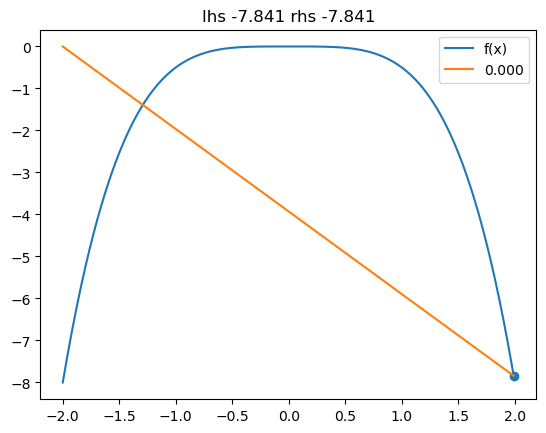

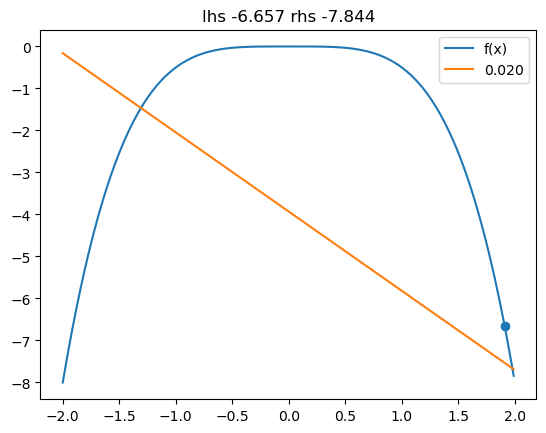

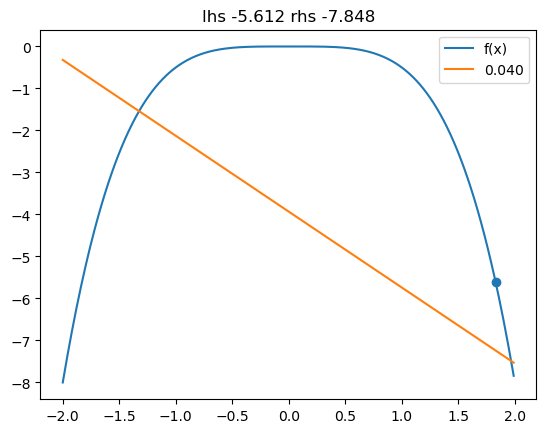

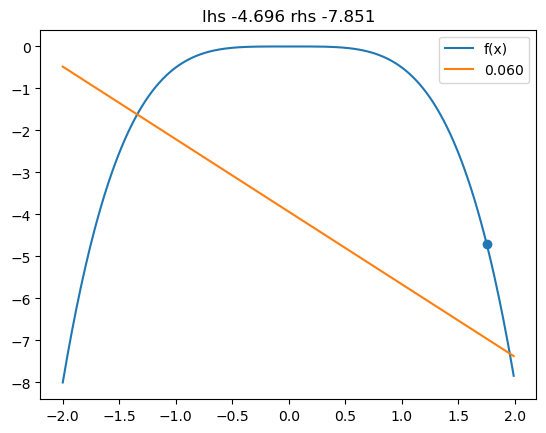

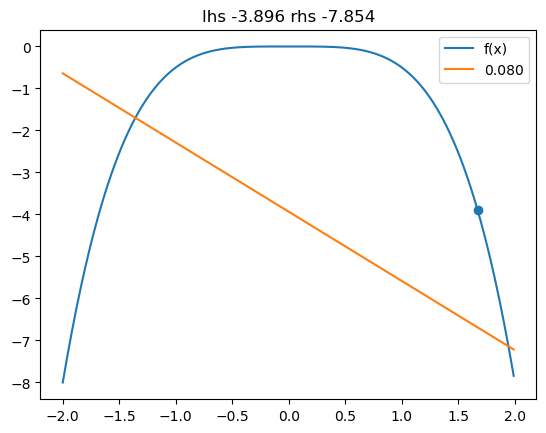

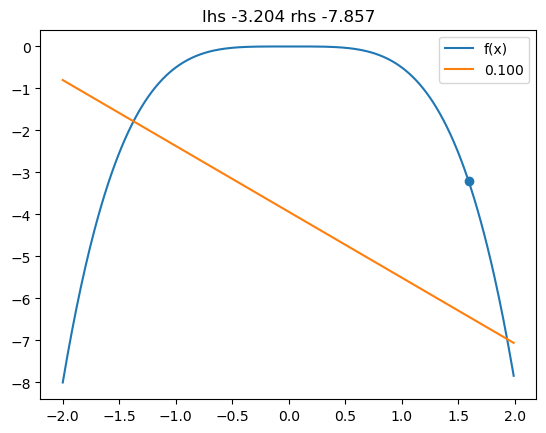

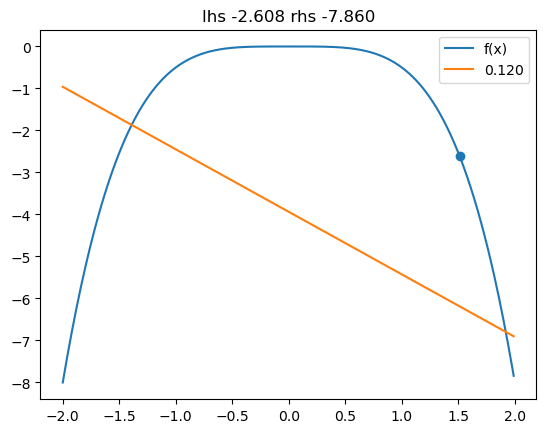

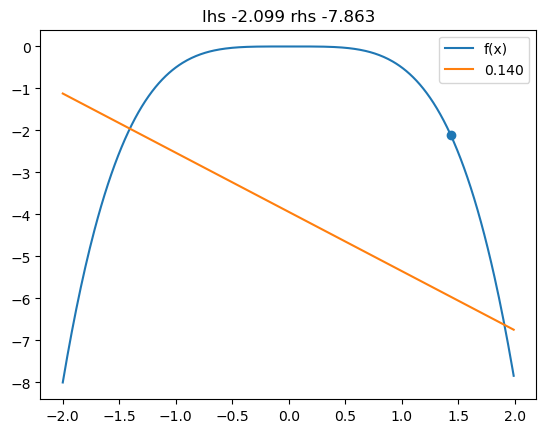

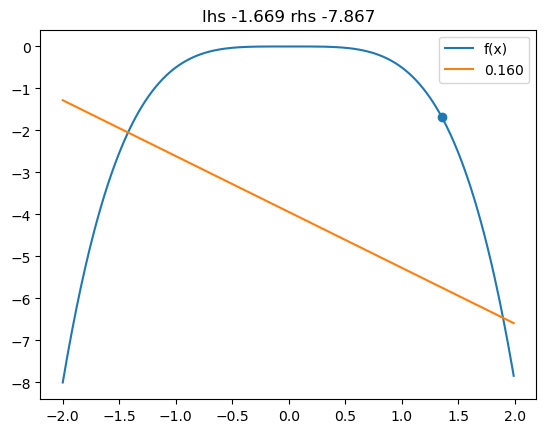

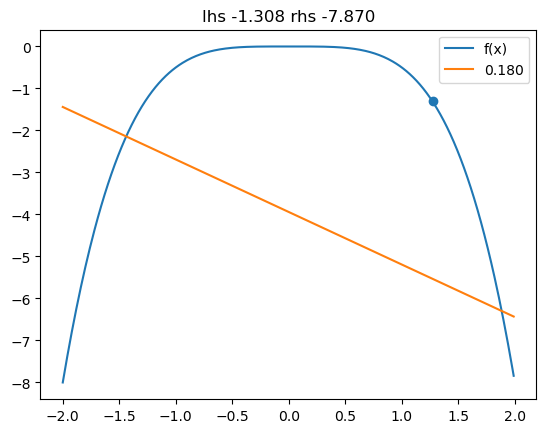

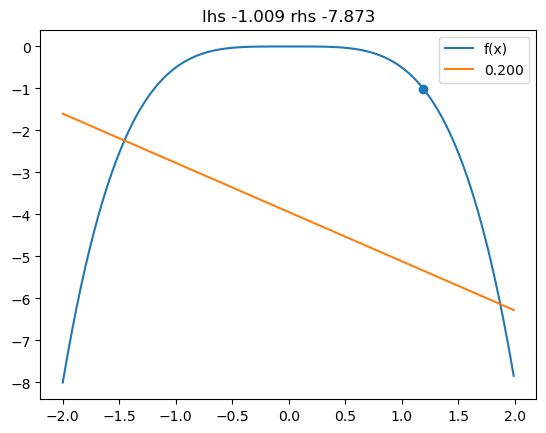

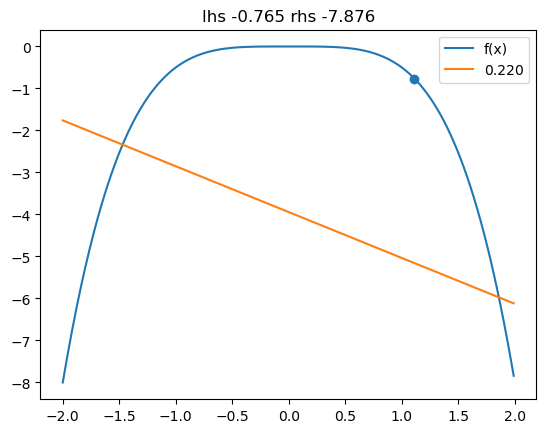

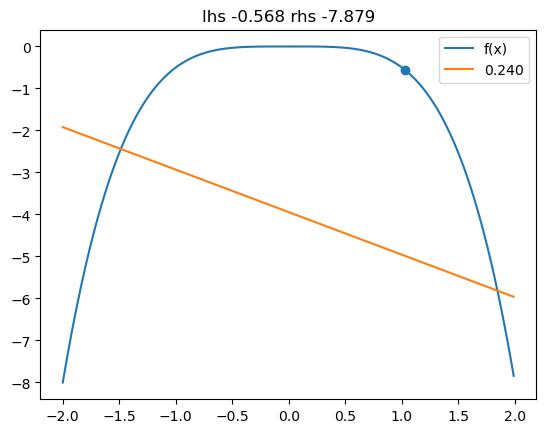

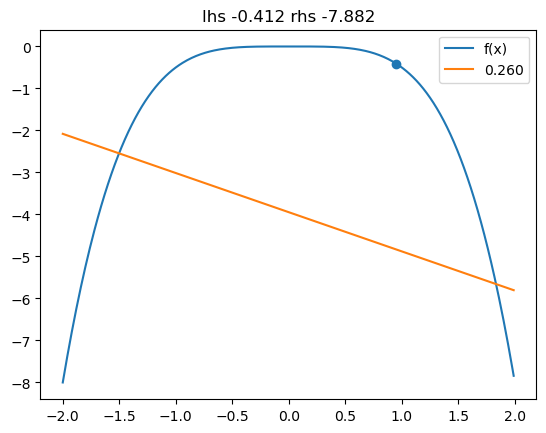

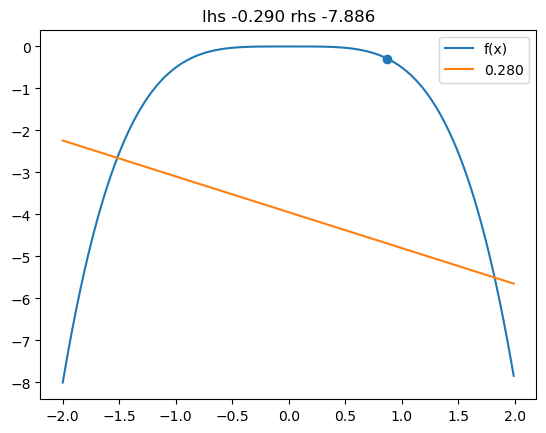

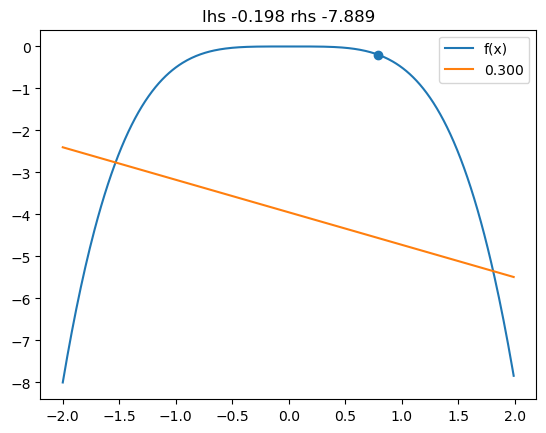

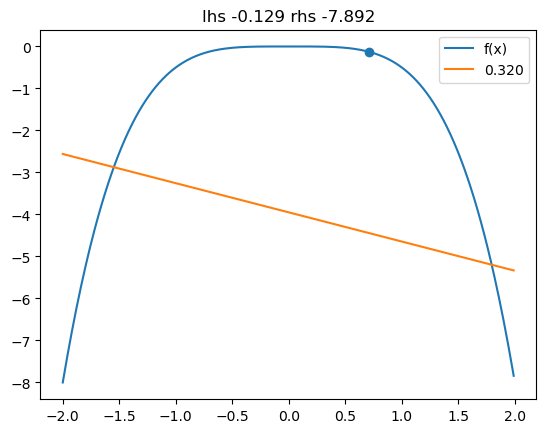

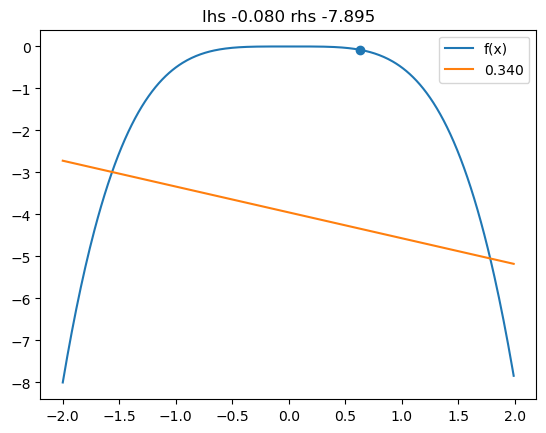

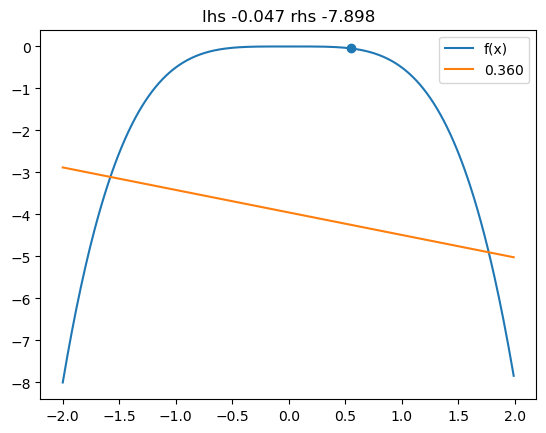

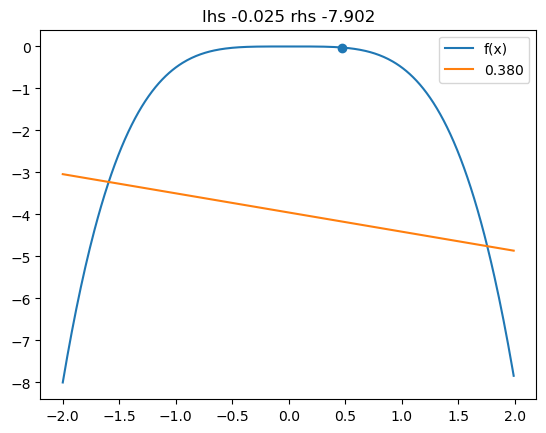

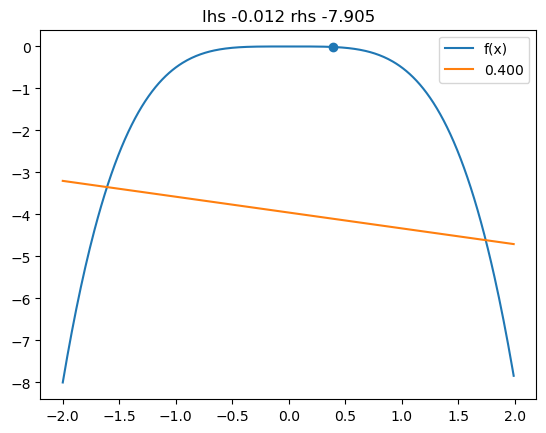

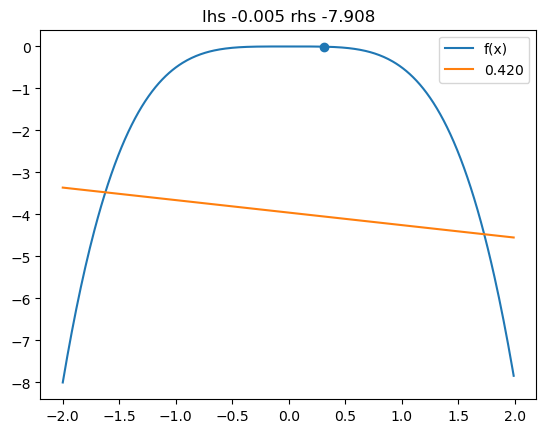

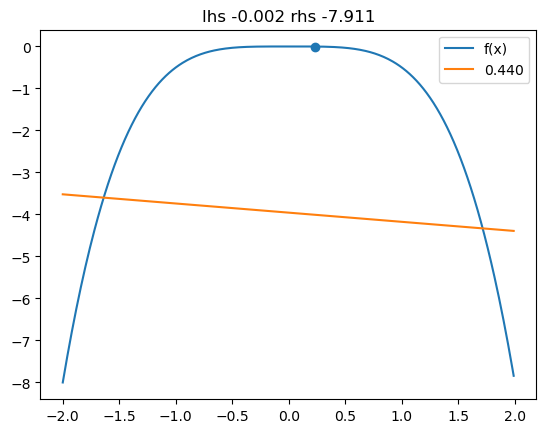

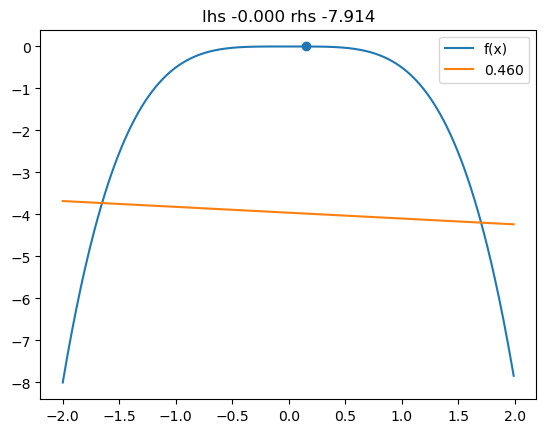

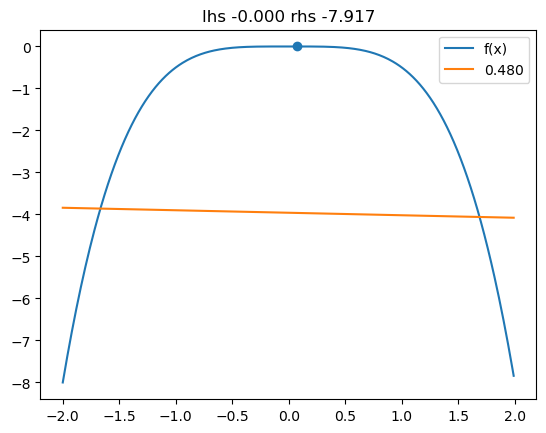

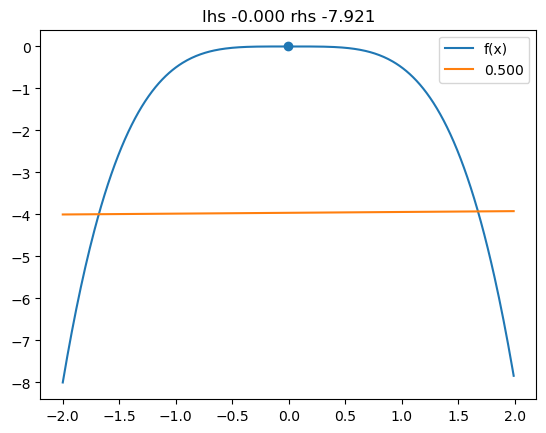

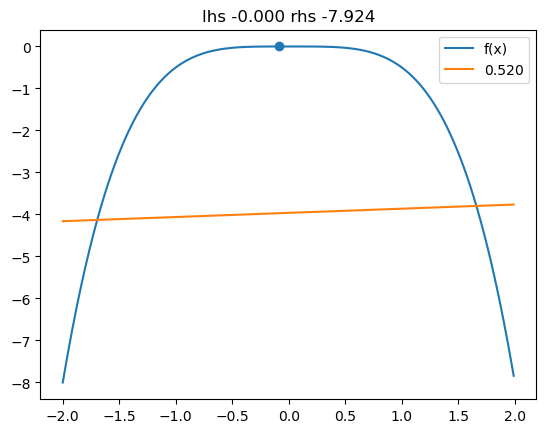

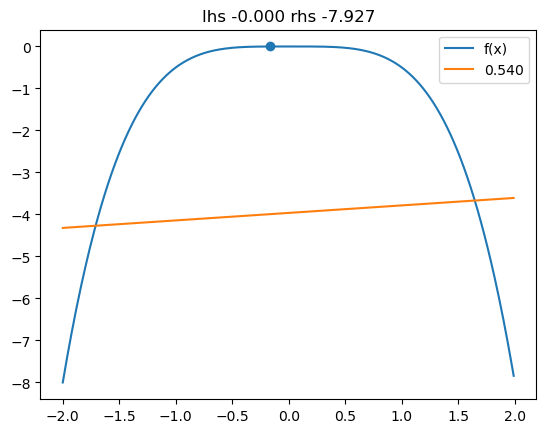

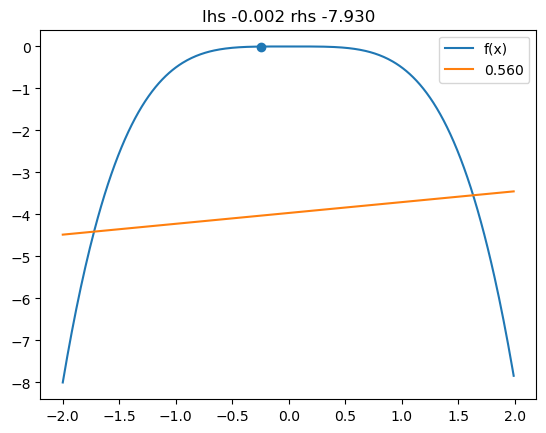

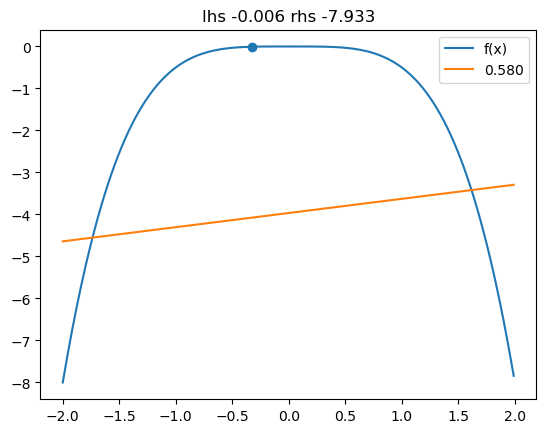

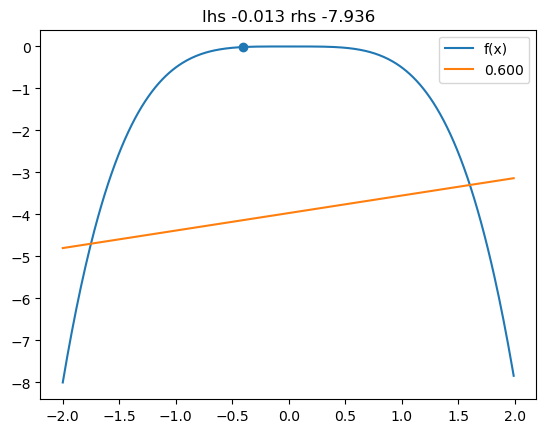

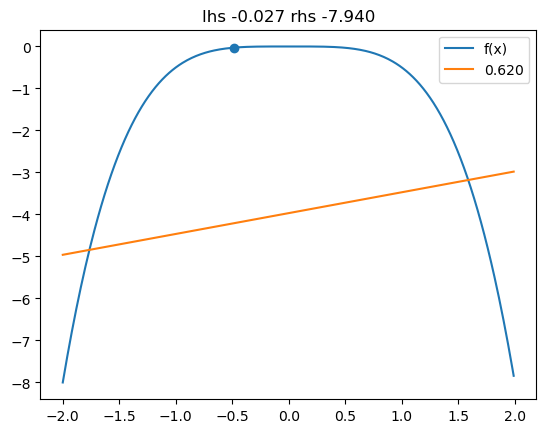

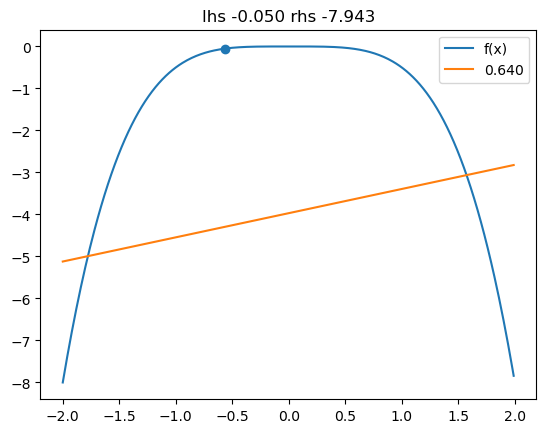

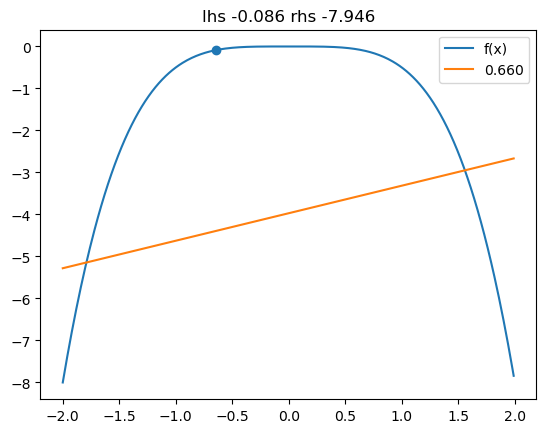

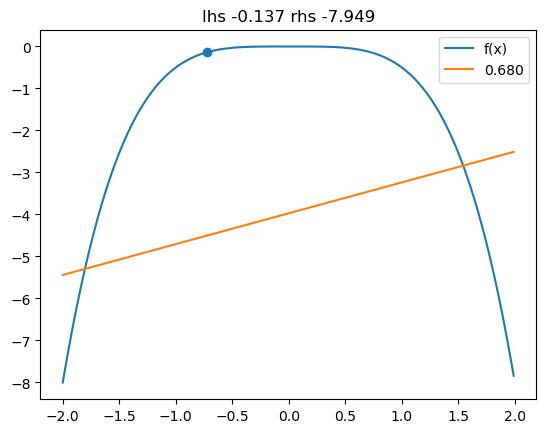

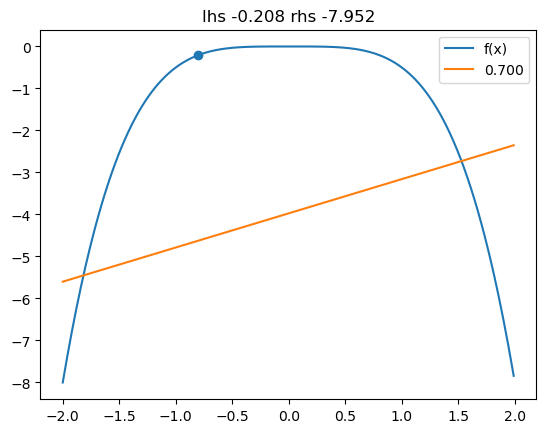

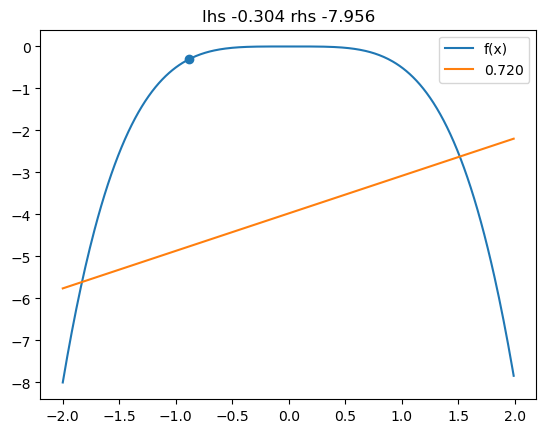

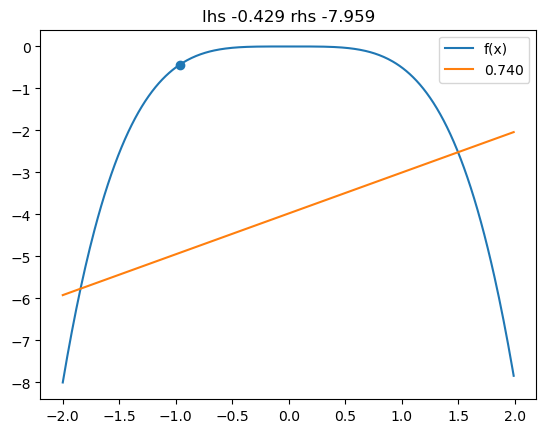

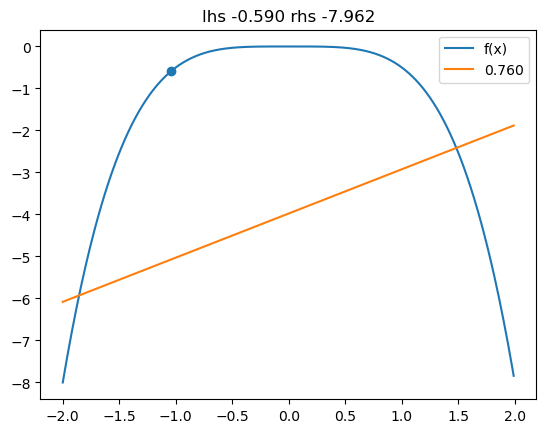

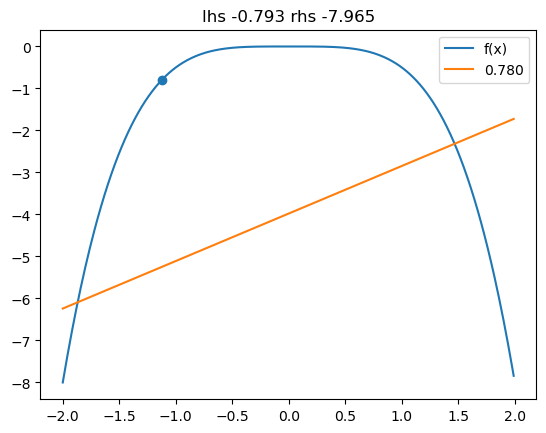

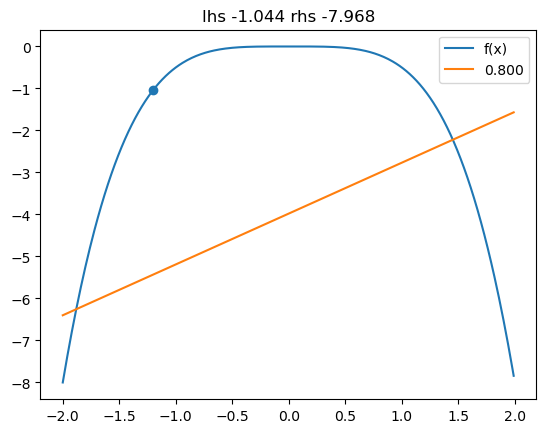

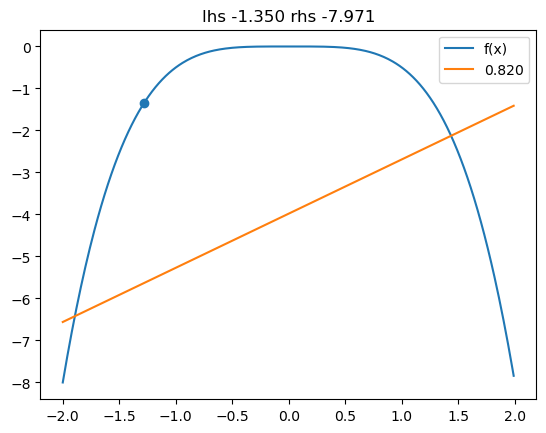

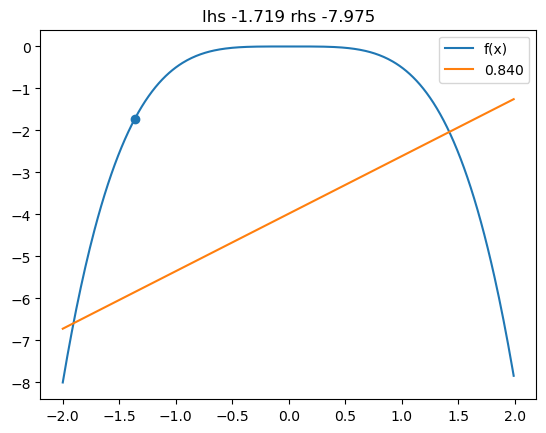

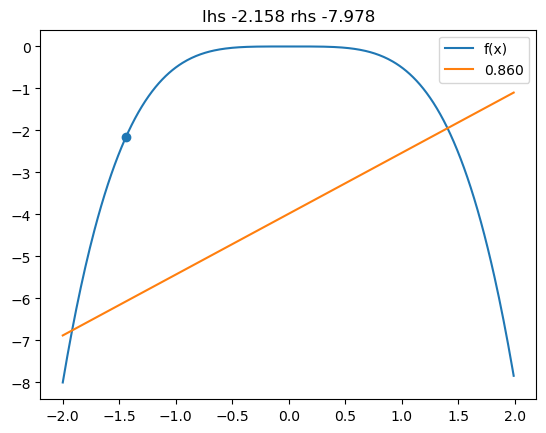

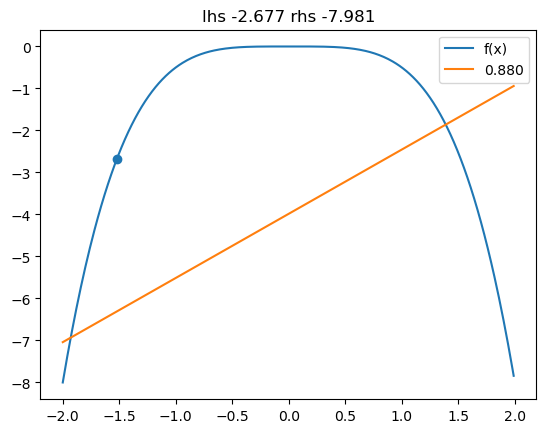

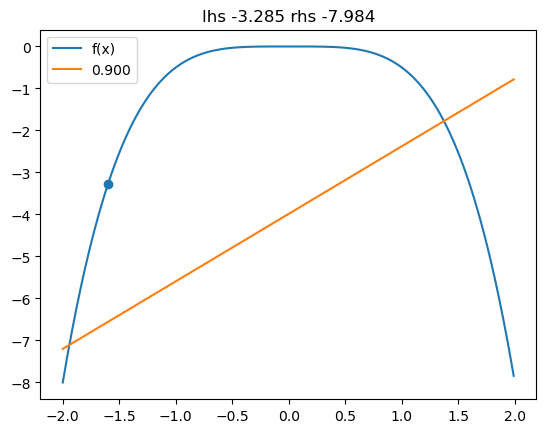

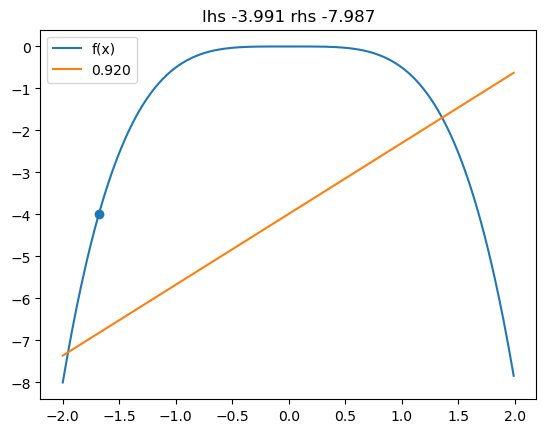

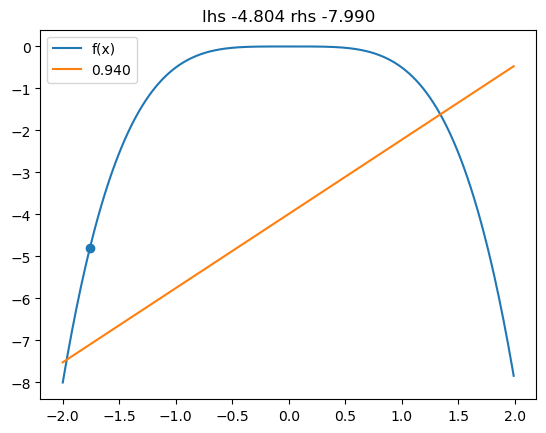

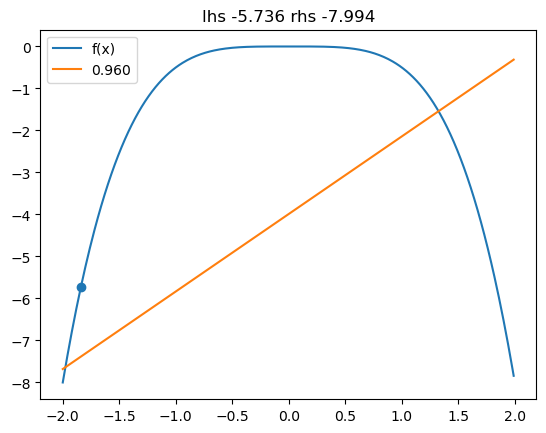

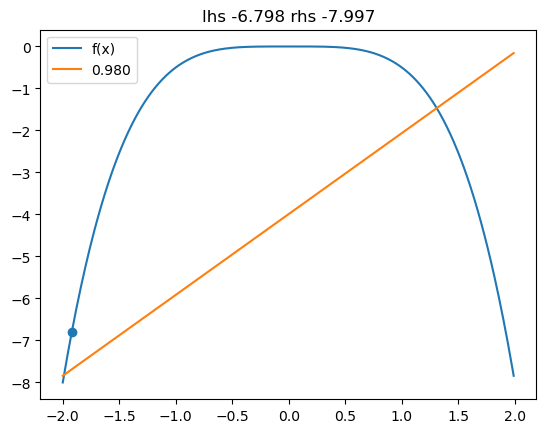

In [150]:
x = np.arange(-2, 2, 0.01)

# 세 개의 함수 중 하나를 선택해서 돌려보세요
# f = lambda x: 0.5 * x ** 2
# f = lambda x: np.cos(np.pi * x)
f = lambda x: -0.5 * x ** 4

filenames=[]
for lamda in np.arange(0, 1, 0.02):
  # LHS
  tmp_x = lamda*x[0] + (1-lamda)*x[-1]

  # RHS
  x_line, y_line = np.array([x[0], x[-1]]), np.array([lamda*f(x[0]), (1-lamda)*f(x[-1])])

  # compute LHS and RHS
  LHS = f(tmp_x)
  RHS = lamda*f(x[0]) + (1-lamda)*f(x[-1])
  if LHS > RHS:
    print('At lamda %0.3f, it is concave' % lamda)
    print('lhs %.5f rhs %.5f' % (LHS, RHS))

  plt.figure()
  # original graph
  plt.plot(x, f(x), label='f(x)')
  # plot RHS
  plt.plot(x_line, y_line, label='%0.3f' % lamda)
  # plot LHS
  plt.scatter(tmp_x, f(tmp_x))
  #title, legennd
  plt.title('lhs %.3f rhs %.3f' % (LHS, RHS))
  plt.legend()
  plt.savefig('lamda %0.3f.png' % lamda)
  # plt.close()
  filenames.append('lamda %0.3f.png' % lamda)

# Build GIF
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

## 질문 3-1: 3개의 함수를 확인할 수 있습니다. 3개의 함수중 최적화가 쉬운 함수는 무엇이고, 왜 그 함수가 최적화하기 쉬울까요?

## 답변 3-1:

첫번째, y = x^2 형태의 2차함수는 실행해보면, U자 모양의 포물선으로 어떤 점에서 최적화를 실행하더라도 최소점을 쉽게 찾을 수 있습니다. (x=0 에서 유일한 최소점이기 때문에)

두번째, y = cos(πx) 형태의 코사인함수는, 물결 모양의 주기함수로, 그렇기에 여러 개의 지역 최소점을 가지게 됩니다. 자연스럽게 어떤 점에서 최적화를 진행하는지에 따라 다른 최소점을 찾게 되고, 그렇기 때문에 전역 최소점을 찾기 어렵게 됩니다.

세번째, y = -(x^4) 형태의 4차 함수는 U를 뒤집은 형태의 위로 볼록한 형태를 나타냅니다. 그렇기 때문에 x가 커질 수록 마이너스가 곱해진 x^4의 값이 빠르게 감소하는 형태로, 정의역이 정해져 있지 않으면 최소값이 마이너스 무한대로 작아지게 되어 의미있는 최소점을 찾기 어려워집니다.

최적화란, 일반적으로 Loss Function을 작게 만드는 것이고, 이러한 결과를 종합해볼 때 y = x^2 형태의 2차함수가 가장 최적화 하기 쉬운 함수임을 알 수 있으며, 임의의 두 점을 이은 직선(할선)이 그 두 점 사이의 함수 곡선보다 위에 있는 함수인 Convex 함수가 최적화가 쉬움을 알 수 있습니다.

## 질문 3-2: 지역 최적해(local minimum)'와 '전역 최적해(global minimum)'의 차이점과 연관 지어, Non-convex 함수를 최적화할 때 발생할 수 있는 문제점은 무엇인지 설명해주세요.

## 답변 3-2:

지역 최소점 (Local Minimum)은 주변 영역에서의 가장 낮은 점, 전역 최소점 (Global Minimum)은 전체 함수에서 가장 낮은 점을 말합니다. 답변 3-1 에서 볼 수 있었던 y = cos(πx) 형태의 코사인함수는 물결 모양의 주기 함수이기 때문에, 여러 개의 지역 최소점을 갖게 됩니다. 
그렇기에 어떤 점에서 최적화를 시작하고 진행하는지에 따라 다른 지역 최소점을 찾게 되며 이 말은 즉, 어떤 점에서 시작하는지에 따라 다른 결과가 발생한다는 의미입니다. 

그렇기에, 모델의 최적화가 어떤 점에서 시작하는지에 따라 다른 결과가 발생하고, 전역 최소점을 찾는 것이 보장되지 않기 때문에 최적의 성능을 달성하기 어려운 문제가 발생할 수 있습니다.
따라서, Non-convex 함수는 최적화가 어렵고 학습 결과가 불안정할 수 있다는 문제점이 있습니다.

# 실습 4 : SGD Optimization

In [151]:
batch_size = 20

def make_data():
    x1 = random.randint(0, 1)
    x2 = random.randint(0, 1)
    yy = 0 if (x1 == x2) else 1

    # centered at zero
    x1 = 2. * (x1 - 0.5)
    x2 = 2. * (x2 - 0.5)
    yy = 2. * (yy - 0.5)

    # add noise
    x1 += 0.1 * random.random()
    x2 += 0.1 * random.random()
    yy += 0.1 * random.random()

    return [x1, x2, ], yy

def make_batch():
    data = [make_data() for ii in range(batch_size)] # 10, 20, 30 중 택 1
    labels = [label for xx, label in data]
    data = [xx for xx, label in data]
    return np.array(data, dtype='float32'), np.array(labels, dtype='float32')

In [152]:
train_data = [make_batch() for ii in range(500)]
test_data = [make_batch() for ii in range(50)]

In [153]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [154]:
torch.manual_seed(42)

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()

        self.dense1 = nn.Linear(2, 2)
        self.dense2 = nn.Linear(2, 1)

    def forward(self, x):
        x = F.tanh(self.dense1(x))
        x = self.dense2(x)
        return torch.squeeze(x)

In [160]:
# initialize our network
model = NN()

## optimizer = stochastic gradient descent
optimizer = optim.SGD(model.parameters(), lr = 0.1)


## train and test functions
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_data):
        data, target = Variable(torch.from_numpy(data)), Variable(torch.from_numpy(target))
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} {}\tLoss: {:.4f}'.format(epoch, batch_idx * len(data), loss.item()))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_data:
        data, target = Variable(torch.from_numpy(data), volatile=True), Variable(torch.from_numpy(target))
        output = model(data)
        test_loss += F.mse_loss(output, target)
        correct += (np.around(output.data.numpy()) == np.around(target.data.numpy())).sum()

    test_loss /= len(test_data)
    test_loss = test_loss.item()

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, batch_size * len(test_data), 100. * correct / (batch_size * len(test_data))) )

In [161]:
## run experiment
nepochs = 100
lr = 0.1

print('lr=', lr)
for epoch in range(1, nepochs + 1):
    train(epoch)
    print('---------------------------------------------')
    test()

lr= 0.1
Train Epoch: 1 0	Loss: 0.9673
Train Epoch: 1 2000	Loss: 0.5459
Train Epoch: 1 4000	Loss: 0.5411
Train Epoch: 1 6000	Loss: 0.4823
Train Epoch: 1 8000	Loss: 0.4882
---------------------------------------------

Test set: Average loss: 0.5128, Accuracy: 496/1000 (49.60%)

Train Epoch: 2 0	Loss: 0.4855
Train Epoch: 2 2000	Loss: 0.5157
Train Epoch: 2 4000	Loss: 0.5283
Train Epoch: 2 6000	Loss: 0.4767
Train Epoch: 2 8000	Loss: 0.4846
---------------------------------------------

Test set: Average loss: 0.5101, Accuracy: 496/1000 (49.60%)

Train Epoch: 3 0	Loss: 0.4828
Train Epoch: 3 2000	Loss: 0.5143
Train Epoch: 3 4000	Loss: 0.5264
Train Epoch: 3 6000	Loss: 0.4756


/var/folders/fd/2ws5rff97879s7zq_p9gb4680000gn/T/ipykernel_30775/3879544526.py:26: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(torch.from_numpy(data), volatile=True), Variable(torch.from_numpy(target))


Train Epoch: 3 8000	Loss: 0.4837
---------------------------------------------

Test set: Average loss: 0.5093, Accuracy: 496/1000 (49.60%)

Train Epoch: 4 0	Loss: 0.4820
Train Epoch: 4 2000	Loss: 0.5138
Train Epoch: 4 4000	Loss: 0.5257
Train Epoch: 4 6000	Loss: 0.4752
Train Epoch: 4 8000	Loss: 0.4832
---------------------------------------------

Test set: Average loss: 0.5089, Accuracy: 496/1000 (49.60%)

Train Epoch: 5 0	Loss: 0.4816
Train Epoch: 5 2000	Loss: 0.5136
Train Epoch: 5 4000	Loss: 0.5253
Train Epoch: 5 6000	Loss: 0.4749
Train Epoch: 5 8000	Loss: 0.4830
---------------------------------------------

Test set: Average loss: 0.5087, Accuracy: 496/1000 (49.60%)

Train Epoch: 6 0	Loss: 0.4813
Train Epoch: 6 2000	Loss: 0.5134
Train Epoch: 6 4000	Loss: 0.5250
Train Epoch: 6 6000	Loss: 0.4747
Train Epoch: 6 8000	Loss: 0.4828
---------------------------------------------

Test set: Average loss: 0.5085, Accuracy: 496/1000 (49.60%)

Train Epoch: 7 0	Loss: 0.4812
Train Epoch: 7 2000

## 실습 4: lr값을 다음 4개의 값으로 돌려보고, 어떤 value가 왜 적절한지 설명해주세요. lr값을 다음 4개의 값으로 돌려보고, 어떤 value가 왜 적절한지 설명해주세요. lr = [0,0001, 0.001, 0.01, 0.1]

## 답변 4  

실행 결과:
### Learning Rate: 0.0001

```
Train Epoch: 1 0	Loss: 1.0729
Train Epoch: 1 2000	Loss: 0.7991
Train Epoch: 1 4000	Loss: 1.0033
Train Epoch: 1 6000	Loss: 0.8850
Train Epoch: 1 8000	Loss: 0.8464
---------------------------------------------

Test set: Average loss: 0.9681, Accuracy: 0/1000 (0.00%)

Train Epoch: 2 0	Loss: 1.0281
Train Epoch: 2 2000	Loss: 0.7923
Train Epoch: 2 4000	Loss: 0.9815
Train Epoch: 2 6000	Loss: 0.8887
Train Epoch: 2 8000	Loss: 0.8454
---------------------------------------------

Test set: Average loss: 0.9459, Accuracy: 0/1000 (0.00%)

Train Epoch: 3 0	Loss: 0.9903
Train Epoch: 3 2000	Loss: 0.7878
Train Epoch: 3 4000	Loss: 0.9644
Train Epoch: 3 6000	Loss: 0.8937
Train Epoch: 3 8000	Loss: 0.8459
---------------------------------------------

(중략: Avarage Loss가 줄어들긴 하지만, Accuracy: 0/1000 으로 유지.)

Test set: Average loss: 0.3177, Accuracy: 261/1000 (26.10%)

Train Epoch: 64 0	Loss: 0.2873
Train Epoch: 64 2000	Loss: 0.3297
Train Epoch: 64 4000	Loss: 0.3342
Train Epoch: 64 6000	Loss: 0.3667
Train Epoch: 64 8000	Loss: 0.3480
---------------------------------------------

Test set: Average loss: 0.3076, Accuracy: 291/1000 (29.10%)

Train Epoch: 65 0	Loss: 0.2781
Train Epoch: 65 2000	Loss: 0.3200
Train Epoch: 65 4000	Loss: 0.3236
Train Epoch: 65 6000	Loss: 0.3552
Train Epoch: 65 8000	Loss: 0.3375
---------------------------------------------

Test set: Average loss: 0.2977, Accuracy: 329/1000 (32.90%)

Train Epoch: 66 0	Loss: 0.2691
Train Epoch: 66 2000	Loss: 0.3106
Train Epoch: 66 4000	Loss: 0.3133
Train Epoch: 66 6000	Loss: 0.3439
Train Epoch: 66 8000	Loss: 0.3271
---------------------------------------------

Test set: Average loss: 0.2880, Accuracy: 492/1000 (49.20%)

Train Epoch: 67 0	Loss: 0.2602
Train Epoch: 67 2000	Loss: 0.3013
Train Epoch: 67 4000	Loss: 0.3031
Train Epoch: 67 6000	Loss: 0.3328
Train Epoch: 67 8000	Loss: 0.3169
---------------------------------------------

Test set: Average loss: 0.2786, Accuracy: 666/1000 (66.60%)

Train Epoch: 68 0	Loss: 0.2516
Train Epoch: 68 2000	Loss: 0.2921
Train Epoch: 68 4000	Loss: 0.2932
Train Epoch: 68 6000	Loss: 0.3220
Train Epoch: 68 8000	Loss: 0.3069
---------------------------------------------

Test set: Average loss: 0.2693, Accuracy: 709/1000 (70.90%)

Train Epoch: 69 0	Loss: 0.2432
Train Epoch: 69 2000	Loss: 0.2831
Train Epoch: 69 4000	Loss: 0.2835
Train Epoch: 69 6000	Loss: 0.3114
Train Epoch: 69 8000	Loss: 0.2972
---------------------------------------------

Test set: Average loss: 0.2602, Accuracy: 736/1000 (73.60%)

Train Epoch: 70 0	Loss: 0.2349
Train Epoch: 70 2000	Loss: 0.2742
Train Epoch: 70 4000	Loss: 0.2741
Train Epoch: 70 6000	Loss: 0.3011
Train Epoch: 70 8000	Loss: 0.2876
---------------------------------------------

Train Epoch: 83 0	Loss: 0.1459
Train Epoch: 83 2000	Loss: 0.1757
Train Epoch: 83 4000	Loss: 0.1716
Train Epoch: 83 6000	Loss: 0.1888
Train Epoch: 83 8000	Loss: 0.1824
---------------------------------------------

Test set: Average loss: 0.1560, Accuracy: 1000/1000 (100.00%)
```

### 요약
- Avarage Loss가 줄어들긴 하지만, Accuracy: 0/1000 으로 유지
- 64 epoch Accuracy: 261/1000 을 달성
- 83 epoch Accuracy: 1000/1000 을 달성

### Learning Rate: 0.001

```
Train Epoch: 1 0	Loss: 1.6660
Train Epoch: 1 2000	Loss: 1.0567
Train Epoch: 1 4000	Loss: 1.0695
Train Epoch: 1 6000	Loss: 1.3581
Train Epoch: 1 8000	Loss: 1.0071
---------------------------------------------

Test set: Average loss: 1.0531, Accuracy: 0/1000 (0.00%)

Train Epoch: 2 0	Loss: 1.0907
Train Epoch: 2 2000	Loss: 1.0206
Train Epoch: 2 4000	Loss: 0.9810
Train Epoch: 2 6000	Loss: 1.0729
Train Epoch: 2 8000	Loss: 0.9867
---------------------------------------------

Test set: Average loss: 0.9911, Accuracy: 0/1000 (0.00%)

Train Epoch: 3 0	Loss: 0.9788
Train Epoch: 3 2000	Loss: 1.0267
Train Epoch: 3 4000	Loss: 0.9753
Train Epoch: 3 6000	Loss: 0.9939
Train Epoch: 3 8000	Loss: 0.9770
---------------------------------------------

Test set: Average loss: 0.7142, Accuracy: 10/1000 (1.00%)

Train Epoch: 11 0	Loss: 0.6944
Train Epoch: 11 2000	Loss: 0.7214
Train Epoch: 11 4000	Loss: 0.7533
Train Epoch: 11 6000	Loss: 0.7247
Train Epoch: 11 8000	Loss: 0.6825
---------------------------------------------

Test set: Average loss: 0.6610, Accuracy: 242/1000 (24.20%)

Train Epoch: 12 0	Loss: 0.6434
Train Epoch: 12 2000	Loss: 0.6629
Train Epoch: 12 4000	Loss: 0.6924
Train Epoch: 12 6000	Loss: 0.6669
Train Epoch: 12 8000	Loss: 0.6159
---------------------------------------------

Train Epoch: 18 0	Loss: 0.1451
Train Epoch: 18 2000	Loss: 0.1050
Train Epoch: 18 4000	Loss: 0.1112
Train Epoch: 18 6000	Loss: 0.1241
Train Epoch: 18 8000	Loss: 0.0905
---------------------------------------------

Test set: Average loss: 0.0907, Accuracy: 999/1000 (99.90%)

Train Epoch: 19 0	Loss: 0.0952
Train Epoch: 19 2000	Loss: 0.0694
Train Epoch: 19 4000	Loss: 0.0702
Train Epoch: 19 6000	Loss: 0.0795
Train Epoch: 19 8000	Loss: 0.0585
---------------------------------------------

Test set: Average loss: 0.0587, Accuracy: 1000/1000 (100.00%)

이하 생략.
```

### 요약
- 11 epoch 에서 Accuracy: 10/1000 기록
- 이후 점점 Avarage Loss가 감소하면서 19 epoch 에서 Accuracy 1000/1000 기록
- Learning Rate가 0.0001 이었을 때에 비해서 빠른 속도로 Loss가 줄어드는 것을 확인할 수 있음 

### Learning Rate: 0.01

```
Train Epoch: 1 0	Loss: 1.5109
Train Epoch: 1 2000	Loss: 0.9861
Train Epoch: 1 4000	Loss: 0.8451
Train Epoch: 1 6000	Loss: 0.9974
Train Epoch: 1 8000	Loss: 0.9238
---------------------------------------------

Test set: Average loss: 0.7188, Accuracy: 16/1000 (1.60%)

Train Epoch: 2 0	Loss: 0.8534
Train Epoch: 2 2000	Loss: 0.6528
Train Epoch: 2 4000	Loss: 0.3736
Train Epoch: 2 6000	Loss: 0.2895
Train Epoch: 2 8000	Loss: 0.1202
---------------------------------------------

Test set: Average loss: 0.0472, Accuracy: 1000/1000 (100.00%)

Train Epoch: 3 0	Loss: 0.0544
Train Epoch: 3 2000	Loss: 0.0100
Train Epoch: 3 4000	Loss: 0.0114
Train Epoch: 3 6000	Loss: 0.0040
Train Epoch: 3 8000	Loss: 0.0021
---------------------------------------------

Test set: Average loss: 0.0015, Accuracy: 1000/1000 (100.00%)
```

### 요약
- Learning Rate가 0.001 이었을 때 보다 더 빠른 속도로 Avarage Loss가 줄어들며, 3 epoch 만에 Avarage Loss가 급격히 줄어듦


### Learning Rate: 0.1

```
Train Epoch: 1 0	Loss: 0.9673
Train Epoch: 1 2000	Loss: 0.5459
Train Epoch: 1 4000	Loss: 0.5411
Train Epoch: 1 6000	Loss: 0.4823
Train Epoch: 1 8000	Loss: 0.4882
---------------------------------------------

Test set: Average loss: 0.5128, Accuracy: 496/1000 (49.60%)

Train Epoch: 2 0	Loss: 0.4855
Train Epoch: 2 2000	Loss: 0.5157
Train Epoch: 2 4000	Loss: 0.5283
Train Epoch: 2 6000	Loss: 0.4767
Train Epoch: 2 8000	Loss: 0.4846
---------------------------------------------

Test set: Average loss: 0.5101, Accuracy: 496/1000 (49.60%)

Train Epoch: 3 0	Loss: 0.4828
Train Epoch: 3 2000	Loss: 0.5143
Train Epoch: 3 4000	Loss: 0.5264
Train Epoch: 3 6000	Loss: 0.4756
Train Epoch: 3 8000	Loss: 0.4837
---------------------------------------------

Test set: Average loss: 0.5093, Accuracy: 496/1000 (49.60%)

Train Epoch: 18 0	Loss: 0.4807
Train Epoch: 18 2000	Loss: 0.5128
Train Epoch: 18 4000	Loss: 0.5241
Train Epoch: 18 6000	Loss: 0.4740
Train Epoch: 18 8000	Loss: 0.4821
---------------------------------------------

Test set: Average loss: 0.5080, Accuracy: 496/1000 (49.60%)

Train Epoch: 19 0	Loss: 0.4806
Train Epoch: 19 2000	Loss: 0.5128
Train Epoch: 19 4000	Loss: 0.5241
Train Epoch: 19 6000	Loss: 0.4740
Train Epoch: 19 8000	Loss: 0.4820
---------------------------------------------

Test set: Average loss: 0.5080, Accuracy: 496/1000 (49.60%)

Train Epoch: 20 0	Loss: 0.4806
Train Epoch: 20 2000	Loss: 0.5128
Train Epoch: 20 4000	Loss: 0.5240
Train Epoch: 20 6000	Loss: 0.4740
Train Epoch: 20 8000	Loss: 0.4820
---------------------------------------------

(중략 - 이후 계속해서 Avarage Loss, Accuracy가 정체되는 모습을 보임)

Test set: Average loss: 0.5078, Accuracy: 496/1000 (49.60%)

Train Epoch: 98 0	Loss: 0.4803
Train Epoch: 98 2000	Loss: 0.5139
Train Epoch: 98 4000	Loss: 0.5228
Train Epoch: 98 6000	Loss: 0.4729
Train Epoch: 98 8000	Loss: 0.4803
---------------------------------------------

Test set: Average loss: 0.5078, Accuracy: 496/1000 (49.60%)

Train Epoch: 99 0	Loss: 0.4803
Train Epoch: 99 2000	Loss: 0.5139
Train Epoch: 99 4000	Loss: 0.5228
Train Epoch: 99 6000	Loss: 0.4729
Train Epoch: 99 8000	Loss: 0.4803
---------------------------------------------

Test set: Average loss: 0.5078, Accuracy: 496/1000 (49.60%)

Train Epoch: 100 0	Loss: 0.4803
Train Epoch: 100 2000	Loss: 0.5139
Train Epoch: 100 4000	Loss: 0.5228
Train Epoch: 100 6000	Loss: 0.4729
Train Epoch: 100 8000	Loss: 0.4803
---------------------------------------------

Test set: Average loss: 0.5078, Accuracy: 496/1000 (49.60%)
```

# 실습 4 - 종합 답변

실습 4는 Stochastic Gradient Descent(SGD) Learning Rate 값에 따라 모델이 어떻게 최적화 되는지, 학습 속도와 안정성에 대해 확인할 수 있는 실습입니다.
Learning Rate 값이 커질수록, loss가 최소가 되는 지점으로 가는 폭이 커지기 때문에 더 빠르게 Loss를 줄일 수 있는 값이 됨을 확인할 수 있었습니다.
0.0001 의 경우 학습 속도가 상대적으로 느리고, 83 epoch가 지나서야 Avarage Loss가 수렴하는 모습을 보였습니다.
0.001의 경우 19 epoch에 수렴하며 0.0001에 비해 더 빠른 학습 속도를 보였습니다. 
0.01 의 경우 3 epoch만에 빠르게 수렴했고, 100 epoch 진행했을 때 Test Loss도 가장 낮았습니다.
그러나 Learning Rate가 0.1로 너무 커지는 경우, 오히려 Loss가 줄어들지 못하고 불안정한 모습을 보였습니다. Rate가 너무 커서, 최적점 주변에서 계속해서 진동하며 Test Loss 0.508에서 정체되어 수렴하지 못했습니다.

이를 통해, Learning Rate가 클 수록 학습 속도가 빠르다는 것을 확인할 수 있었으며, 업데이트 폭이 너무 큰 경우 불안정 할 수 있다는 사실도 확인했습니다.
결론적으로, 위 실습에서는 Learning Rate를 0.01로 설정하는 것이 가장 적절한 것으로 보이며, 모델을 올바르게 학습시키기 위해서 Optimization 과정에서 적절한 Learning Rate 값을 찾는 것이 중요하다는 점을 확인할 수 있었습니다.

# 실습 5: Sigmoid Function

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [7]:
f = lambda x, w, b: 1/(1 + np.exp(-(w*x + b)))

x = np.arange(-10, 10, 0.01).reshape([-1, 1])

# effect of weight on sigmoid function
filenames = []
for i in np.arange(1, 5, 0.1):
  w = np.ones([1, 1]) * i * 0.5
  b = np.ones([1, 1]) * 0

  plt.plot(x, f(x, w, b))
  plt.title('w = %0.1f' % i)
  plt.grid()
  plt.savefig('w %0.1f.png' % i)
  plt.close()
  filenames.append('w %0.1f.png' % i)

# Build GIF
with imageio.get_writer('w_mygif.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)


/var/folders/fd/2ws5rff97879s7zq_p9gb4680000gn/T/ipykernel_41634/2666614901.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [8]:
f = lambda x, w, b: 1/(1 + np.exp(-(w*x + b)))

x = np.arange(-10, 10, 0.01).reshape([-1, 1])

# effect of bias on sigmoid function
filenames = []
for i in np.arange(1, 5, 0.1):
  w = np.ones([1, 1])
  b = np.ones([1, 1])* i

  plt.plot(x, f(x, w, b))
  plt.title('b = %0.1f' % i)
  plt.grid()
  plt.savefig('b %0.1f.png' % i)
  plt.close()
  filenames.append('b %0.1f.png' % i)

# Build GIF
with imageio.get_writer('b_mygif.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

/var/folders/fd/2ws5rff97879s7zq_p9gb4680000gn/T/ipykernel_41634/3310009339.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


# 실습 6: Logistic Regression

In [11]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [12]:
input_size = 28 * 28  # 784
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

In [13]:
train_dataset = torchvision.datasets.MNIST(root='../../data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data',
                                          train=False,
                                          transform=transforms.ToTensor(),
                                          download=True)

# Data loader (input pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

100%|██████████| 9.91M/9.91M [00:02<00:00, 3.45MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.55MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.26MB/s]


Dataset MNIST
    Number of datapoints: 60000
    Root location: ../../data
    Split: Train
    StandardTransform
Transform: ToTensor()
----------------
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../../data
    Split: Test
    StandardTransform
Transform: ToTensor()

training data shape:  torch.Size([60000, 28, 28])


/opt/anaconda3/lib/python3.13/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Text(0.5, 1.0, 'n = 54618 label = 6')

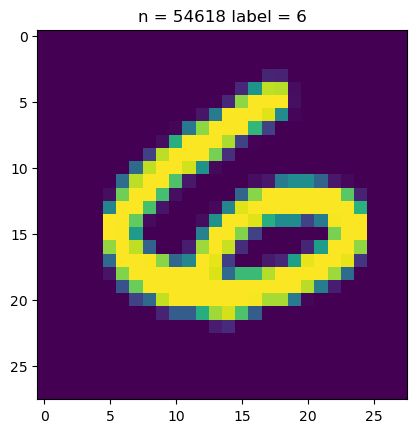

In [14]:
# 2.3.1 Check data
print(train_dataset)
print('----------------')
print(test_dataset)
print()

import matplotlib.pyplot as plt
print('training data shape: ', train_dataset.data.shape)
n = np.random.randint(0, 60000)
plt.imshow(train_dataset.data[n])
plt.title(f'n = %d label = %d' % (n, train_dataset.train_labels[n].numpy()))

In [15]:
#2.4 Logistic regression model
model = nn.Linear(input_size, num_classes)

#2.5 Cross Entropy Loss
# nn.CrossEntropyLoss() computes softmax internally
criterion = nn.CrossEntropyLoss()

#2.6 Optimizer Stochastic Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#2.7 Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Reshape images to (batch_size, input_size)
        images = images.reshape(-1, input_size)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


Epoch [1/5], Step [100/600], Loss: 2.2055
Epoch [1/5], Step [200/600], Loss: 2.1188
Epoch [1/5], Step [300/600], Loss: 2.0387
Epoch [1/5], Step [400/600], Loss: 1.9635
Epoch [1/5], Step [500/600], Loss: 1.8688
Epoch [1/5], Step [600/600], Loss: 1.7515
Epoch [2/5], Step [100/600], Loss: 1.6842
Epoch [2/5], Step [200/600], Loss: 1.6318
Epoch [2/5], Step [300/600], Loss: 1.6378
Epoch [2/5], Step [400/600], Loss: 1.5976
Epoch [2/5], Step [500/600], Loss: 1.4684
Epoch [2/5], Step [600/600], Loss: 1.5359
Epoch [3/5], Step [100/600], Loss: 1.4255
Epoch [3/5], Step [200/600], Loss: 1.4208
Epoch [3/5], Step [300/600], Loss: 1.4278
Epoch [3/5], Step [400/600], Loss: 1.3461
Epoch [3/5], Step [500/600], Loss: 1.2055
Epoch [3/5], Step [600/600], Loss: 1.2284
Epoch [4/5], Step [100/600], Loss: 1.2906
Epoch [4/5], Step [200/600], Loss: 1.1442
Epoch [4/5], Step [300/600], Loss: 1.1152
Epoch [4/5], Step [400/600], Loss: 1.2145
Epoch [4/5], Step [500/600], Loss: 1.1521
Epoch [4/5], Step [600/600], Loss:

In [16]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, input_size)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the model on the 10000 test images: 82.87000274658203 %


## 코드 구현 6-1 : 아래 log_softmax함수를 구현하세요.

In [17]:
class custom_CrossEntropyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(custom_CrossEntropyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        num_examples = targets.shape[0]
        batch_size = inputs.shape[0]
        softmax_outputs = self.log_softmax(inputs)
        outputs = softmax_outputs[range(batch_size), targets]
        return -torch.sum(outputs)/num_examples

    @staticmethod
    def log_softmax(x):
        return x - torch.log(torch.sum(torch.exp(x), dim=1, keepdim=True))

In [18]:
#2.4 Logistic regression model
model = nn.Linear(input_size, num_classes)

#2.5 Cross Entropy Loss
# nn.CrossEntropyLoss() computes softmax internally
criterion = nn.CrossEntropyLoss()

#2.6 Optimizer Stochastic Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#2.7 Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Reshape images to (batch_size, input_size)
        images = images.reshape(-1, input_size)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [100/600], Loss: 2.1984
Epoch [1/5], Step [200/600], Loss: 2.1114
Epoch [1/5], Step [300/600], Loss: 2.0105
Epoch [1/5], Step [400/600], Loss: 1.9402
Epoch [1/5], Step [500/600], Loss: 1.8537
Epoch [1/5], Step [600/600], Loss: 1.7613
Epoch [2/5], Step [100/600], Loss: 1.7113
Epoch [2/5], Step [200/600], Loss: 1.6456
Epoch [2/5], Step [300/600], Loss: 1.6112
Epoch [2/5], Step [400/600], Loss: 1.5503
Epoch [2/5], Step [500/600], Loss: 1.4428
Epoch [2/5], Step [600/600], Loss: 1.5073
Epoch [3/5], Step [100/600], Loss: 1.4527
Epoch [3/5], Step [200/600], Loss: 1.3569
Epoch [3/5], Step [300/600], Loss: 1.3567
Epoch [3/5], Step [400/600], Loss: 1.2653
Epoch [3/5], Step [500/600], Loss: 1.3049
Epoch [3/5], Step [600/600], Loss: 1.1720
Epoch [4/5], Step [100/600], Loss: 1.2131
Epoch [4/5], Step [200/600], Loss: 1.0675
Epoch [4/5], Step [300/600], Loss: 1.1432
Epoch [4/5], Step [400/600], Loss: 1.2351
Epoch [4/5], Step [500/600], Loss: 1.1675
Epoch [4/5], Step [600/600], Loss:

In [19]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, input_size)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the model on the 10000 test images: 83.08000183105469 %


## 질문 6 : 다중 분류 문제에서는 왜 sigmoid를 사용하지 못하고 softmax를 사용하게 될까요?

## 답변 6

다중 분류 문제에서 Sigmoid Function을 사용하지 못하는 이유는, Sigmoid는 확률 분포가 아니기 때문입니다. 다중 분류 문제는 "여러 개 중 어떤 것이 가장 맞는지?" 에 대한 판단을 하는 문제입니다. 그러나 Sigmoid는 각 클래스에 대해 독립적으로 확률을 갖기 때문에, 특정 클래스가 높지만 다른 클래스 또한 꽤 높을 수 있습니다. 그래서, 여러 개 중 하나 라는 관계를 표현하기에 명확하지 않으며, 클래스 간의 비교를 하기에 적합하지 않습니다.
Softmax의 경우에는 확률 분포입니다. 전체의 합이 1이며 다른 항의 결과가 내 결과에 반영이 되는 방식(분모에 모든 클래스가 들어가는)이기 때문에 하나의 정답을 가져야 하는 다중 분류 문제에서 클래스 간의 비교를 명확하게 할 수 있습니다.